In [ ]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=8d6ca8a6cf067c92ec0bea94b75bef2d86932aab9c709174f097e98f2bc2bab6
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 64.9 MB/s eta 0:00:00


In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

simulator = AerSimulator()

def generate_bits_and_bases(n):
    bits = np.random.randint(2, size=n)
    bases = np.random.randint(2, size=n)
    return bits, bases

def encode_qubits(bits, bases):
    circuits = []
    for bit, basis in zip(bits, bases):
        qc = QuantumCircuit(1, 1)
        if bit == 1:
            qc.x(0)
        if basis == 1:
            qc.h(0)
        circuits.append(qc)
    return circuits

def eavesdrop(circuits, eaves_bases):
    new_circuits = []
    for qc, basis in zip(circuits, eaves_bases):
        temp_qc = qc.copy()
        if basis == 1:
            temp_qc.h(0)
        temp_qc.measure(0, 0)

        tqc = transpile(temp_qc, simulator)
        result = simulator.run(tqc, shots=1, memory=True).result()
        measurement = result.get_memory()[0]

        resend = QuantumCircuit(1, 1)
        if int(measurement) == 1:
            resend.x(0)
        if basis == 1:
            resend.h(0)
        new_circuits.append(resend)
    return new_circuits

def measure_qubits(circuits, bob_bases):
    results = []
    for qc, basis in zip(circuits, bob_bases):
        temp_qc = qc.copy()
        if basis == 1:
            temp_qc.h(0)
        temp_qc.measure(0, 0)
        tqc = transpile(temp_qc, simulator)
        result = simulator.run(tqc, shots=1, memory=True).result()
        results.append(int(result.get_memory()[0]))
    return results

def sift_key(alice_bases, bob_bases, alice_bits, bob_results):
    sifted_alice = []
    sifted_bob = []
    for ab, bb, ab_bit, br in zip(alice_bases, bob_bases, alice_bits, bob_results):
        if ab == bb:
            sifted_alice.append(ab_bit)
            sifted_bob.append(br)
    return sifted_alice, sifted_bob

def estimate_error_rate(sifted_alice, sifted_bob):
    if not sifted_alice:
        return 0
    errors = sum(a != b for a, b in zip(sifted_alice, sifted_bob))
    return errors / len(sifted_alice)


import matplotlib.pyplot as plt

def plot_qber_vs_eavesdropping():
    trials = 10
    n = 100
    qber_no_eve = []
    qber_with_eve = []

    for _ in range(trials):
        # No Eve
        alice_bits, alice_bases = generate_bits_and_bases(n)
        bob_bases = generate_bits_and_bases(n)[1]
        circuits = encode_qubits(alice_bits, alice_bases)
        bob_results = measure_qubits(circuits, bob_bases)
        sifted_alice, sifted_bob = sift_key(alice_bases, bob_bases, alice_bits, bob_results)
        qber_no_eve.append(estimate_error_rate(sifted_alice, sifted_bob))

        # With Eve
        alice_bits, alice_bases = generate_bits_and_bases(n)
        bob_bases = generate_bits_and_bases(n)[1]
        eaves_bases = generate_bits_and_bases(n)[1]
        circuits = encode_qubits(alice_bits, alice_bases)
        circuits = eavesdrop(circuits, eaves_bases)
        bob_results = measure_qubits(circuits, bob_bases)
        sifted_alice, sifted_bob = sift_key(alice_bases, bob_bases, alice_bits, bob_results)
        qber_with_eve.append(estimate_error_rate(sifted_alice, sifted_bob))

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(qber_no_eve, label='No Eve (Secure Channel)', marker='o')
    plt.plot(qber_with_eve, label='With Eve (Intercepted)', marker='x')
    plt.axhline(y=0.25, color='gray', linestyle='--', label='Random Guessing Error (25%)')
    plt.xlabel('Trial')
    plt.ylabel('Quantum Bit Error Rate (QBER)')
    plt.title('QBER With vs. Without Eavesdropping in BB84')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Sifted key length: 45
Estimated error rate: 0.35555555555555557
Sifted Alice Key: [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]
Sifted Bob Key:   [1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1]


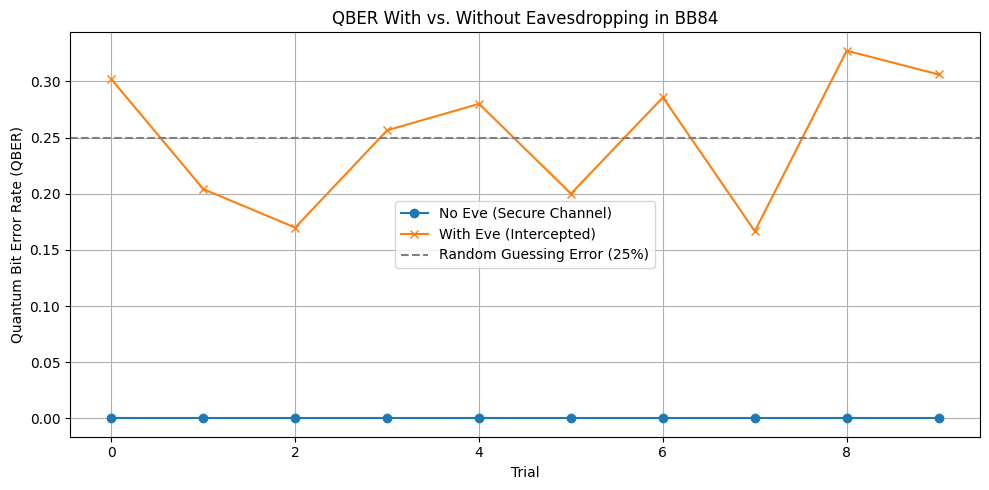

In [ ]:
if __name__ == "__main__":
    n = 100
    alice_bits, alice_bases = generate_bits_and_bases(n)
    bob_bases = generate_bits_and_bases(n)[1]
    eaves_bases = generate_bits_and_bases(n)[1]

    circuits = encode_qubits(alice_bits, alice_bases)

    # Uncomment this line to simulate eavesdropping
    circuits = eavesdrop(circuits, eaves_bases)

    bob_results = measure_qubits(circuits, bob_bases)

    sifted_alice, sifted_bob = sift_key(alice_bases, bob_bases, alice_bits, bob_results)
    error = estimate_error_rate(sifted_alice, sifted_bob)

    print("Sifted key length:", len(sifted_alice))
    print("Estimated error rate:", error)
    print("Sifted Alice Key:", sifted_alice)
    print("Sifted Bob Key:  ", sifted_bob)
    plot_qber_vs_eavesdropping() ### This line could take a while!

